# Exploration

Here we perform some basic exploration of the SECOP II dataset in order to get basic insights and get some ideas on how to process the data for training the model.

In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import re

from sklearn.feature_extraction.text import CountVectorizer

np.random.seed(987)
plt.style.use("seaborn")

# Data Loading

In [2]:
raw_file = os.path.join("..", "data", "raw", "raw_data.csv")
df_raw = pd.read_csv(raw_file)

print(df_raw.shape)
print(df_raw.columns)

df_raw.head()

(500000, 2)
Index(['descripcion_del_proceso', 'codigo_de_categoria_principal'], dtype='object')


,descripcion_del_proceso,codigo_de_categoria_principal
0,Prestar los servicios profesionales de apoyo j...,V1.77101604
1,CONTRATAR EL SERVICIO DE GESTIÓN DE EVENTOS O ...,V1.90101604
2,Censo_Economico_2021_SECGEN_BDMGN_TH Prestació...,V1.80111500
3,PRESTAR SERVICIOS DE CARÁCTER TEMPORAL COMO IN...,V1.80111600
4,AUNAR ESFUERZOS ENTRE EL DEPARTAMENTO Y EL MUN...,V1.72141003


In [3]:
#We'll use a sample of our dataset to reduce data allocation.

df_sample = df_raw.sample(10000).reset_index().drop(columns='index')

In [4]:
pd.isnull(df_sample).sum()

descripcion_del_proceso          0
codigo_de_categoria_principal    0
dtype: int64

As we can see, there are no entries without description or UNSPSC code.

#  Load UNSPSC Codes References

In [5]:
unspsc_file = os.path.join("..","references","clasificador_de_bienes_y_servicios_v14_1.xlsx")
df_unspsc = pd.read_excel(unspsc_file)

print(df_unspsc.shape)
print(df_unspsc.columns)

df_unspsc.head()

(49022, 8)
Index(['Código Segmento', 'Nombre Segmento', 'Código Familia',
       'Nombre Familia', 'Código Clase', 'Nombre Clase', 'Código Producto',
       'Nombre Producto'],
      dtype='object')


,Código Segmento,Nombre Segmento,Código Familia,Nombre Familia,Código Clase,Nombre Clase,Código Producto,Nombre Producto
0,10,"Material Vivo Vegetal y Animal, Accesorios y S...",1010,Animales vivos,101015,Animales de granja,10101501,Gatos
1,10,"Material Vivo Vegetal y Animal, Accesorios y S...",1010,Animales vivos,101015,Animales de granja,10101502,Perros
2,10,"Material Vivo Vegetal y Animal, Accesorios y S...",1010,Animales vivos,101015,Animales de granja,10101504,Visón
3,10,"Material Vivo Vegetal y Animal, Accesorios y S...",1010,Animales vivos,101015,Animales de granja,10101505,Ratas
4,10,"Material Vivo Vegetal y Animal, Accesorios y S...",1010,Animales vivos,101015,Animales de granja,10101506,Caballos


In [6]:
segment_dict = dict(
    zip(
        df_unspsc['Código Segmento'].astype('str'),
        df_unspsc['Nombre Segmento']
    )
)
family_dict = dict(
    zip(
        df_unspsc['Código Familia'].astype('str'),
        df_unspsc['Nombre Familia']
    )
)
class_dict = dict(
    zip(
        df_unspsc['Código Clase'].astype('str'),
        df_unspsc['Nombre Clase']
    )
)
commodity_dict = dict(
    zip(
        df_unspsc['Código Producto'].astype('str'),
        df_unspsc['Nombre Producto']
    )
)

# Transform UNSPSC codes to topics

In [7]:
df_sample['codigo_de_categoria_principal'] = df_sample['codigo_de_categoria_principal'].str.extract('([0-9]{8})', expand=False)

df_sample['segment_code'] = df_sample['codigo_de_categoria_principal'].str[:2]
df_sample['family_code'] = df_sample['codigo_de_categoria_principal'].str[:4]
df_sample['class_code'] = df_sample['codigo_de_categoria_principal'].str[:6]
df_sample['commodity_code'] = df_sample['codigo_de_categoria_principal'].str[:8]

df_sample.head()

,descripcion_del_proceso,codigo_de_categoria_principal,segment_code,family_code,class_code,commodity_code
0,SUMINISTRO DE MEDICAMENTOS AMBULATORIOS PARA L...,51101500,51,5110,511015,51101500
1,Prestar con plena autonomía técnica y administ...,86141704,86,8614,861417,86141704
2,Prestación de Servicios Profesionales como Abo...,80111501,80,8011,801115,80111501
3,PRESTAR SERVICIOS PROFESIONALES DE CARÁCTER TE...,80111600,80,8011,801116,80111600
4,Prestar servicios personales de carácter tempo...,86101710,86,8610,861017,86101710


In [8]:
df_sample['segment_text'] = df_sample.segment_code.map(segment_dict)
df_sample['family_text'] = df_sample.family_code.map(family_dict)
df_sample['class_text'] = df_sample.class_code.map(class_dict)
df_sample['commodity_text'] = df_sample.commodity_code.map(commodity_dict)

df_sample.head(10)

,descripcion_del_proceso,codigo_de_categoria_principal,segment_code,family_code,class_code,commodity_code,segment_text,family_text,class_text,commodity_text
0,SUMINISTRO DE MEDICAMENTOS AMBULATORIOS PARA L...,51101500,51,5110,511015,51101500,Medicamentos y Productos Farmacéuticos,Medicamentos antiinfecciosos,Antibióticos,NaN
1,Prestar con plena autonomía técnica y administ...,86141704,86,8614,861417,86141704,Servicios Educativos y de Formación,Instalaciones educativas,Tecnología educacional,Servicios de biblioteca o documentación
2,Prestación de Servicios Profesionales como Abo...,80111501,80,8011,801115,80111501,"Servicios de Gestión, Servicios Profesionales ...",Servicios de recursos humanos,Desarrollo de recursos humanos,Perfeccionamiento de la función de gestión
3,PRESTAR SERVICIOS PROFESIONALES DE CARÁCTER TE...,80111600,80,8011,801116,80111600,"Servicios de Gestión, Servicios Profesionales ...",Servicios de recursos humanos,Servicios de personal temporal,NaN
4,Prestar servicios personales de carácter tempo...,86101710,86,8610,861017,86101710,Servicios Educativos y de Formación,Formación profesional,Servicios de capacitación vocacional no - cien...,Servicios de formación pedagógica
5,Entregar a título de comodato a la Policía Nac...,95101800,95,9510,951018,95101800,"Terrenos, Edificios, Estructuras y Vías",Parcelas de tierra,Lotes de terrenos gubernamentales,NaN
6,PRESTACIÓN DE SERVICIOS PROFESIONALES COMO PSI...,80111600,80,8011,801116,80111600,"Servicios de Gestión, Servicios Profesionales ...",Servicios de recursos humanos,Servicios de personal temporal,NaN
7,Apoyar a la Dirección de Infraestructura Socia...,80111600,80,8011,801116,80111600,"Servicios de Gestión, Servicios Profesionales ...",Servicios de recursos humanos,Servicios de personal temporal,NaN
8,FORTALECER LA GESTIÓN DEL MODELO DE ATENCIÓN ...,85101605,85,8510,851016,85101605,Servicios de Salud,Servicios integrales de salud,Personas de soporte de prestación de servicios...,Auxiliares de salud a domicilio
9,PRESTACIÓN DE SERVICIOS DE APOYO A LA GESTIÓN ...,85101600,85,8510,851016,85101600,Servicios de Salud,Servicios integrales de salud,Personas de soporte de prestación de servicios...,NaN


In [9]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   descripcion_del_proceso        30000 non-null  object
 1   codigo_de_categoria_principal  29963 non-null  object
 2   segment_code                   29963 non-null  object
 3   family_code                    29963 non-null  object
 4   class_code                     29963 non-null  object
 5   commodity_code                 29963 non-null  object
 6   segment_text                   29963 non-null  object
 7   family_text                    29963 non-null  object
 8   class_text                     29963 non-null  object
 9   commodity_text                 12484 non-null  object
dtypes: object(10)
memory usage: 2.3+ MB


Here we can see that there are few descriptions that doesn't have codes. Also, There are a lot of codes without a specific commodity classification.

# Description Lenght Exploration

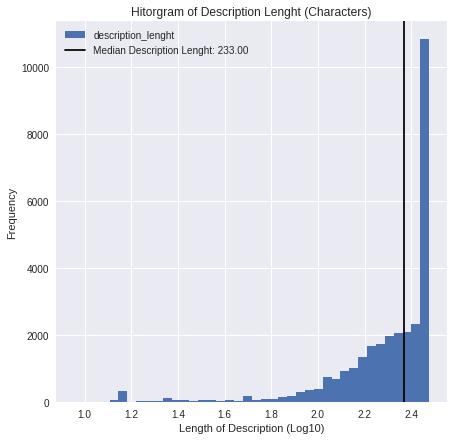

In [10]:
df_sample["description_lenght"] = df_sample.descripcion_del_proceso.map(len)

fig, ax = plt.subplots(figsize=(7, 7))
lens_log10 = df_sample["description_lenght"].map(np.log10)
lens_log10.plot.hist(bins=40, ax=ax)

median_len = lens_log10.median()
ax.axvline(median_len, label=f"Median Description Lenght: {10 ** median_len:0.2f}", color="black")

ax.set_title("Hitorgram of Description Lenght (Characters)")
ax.set_xlabel("Length of Description (Log10)")
ax.legend()
plt.show()

From these basic histograms of description texts, we can see that mosk contracts texts are rather short, with a median description length of around 232 characters (10 ^ 2,36). This in turn corresponds to around 35 - 45 words.

# Segments explorations

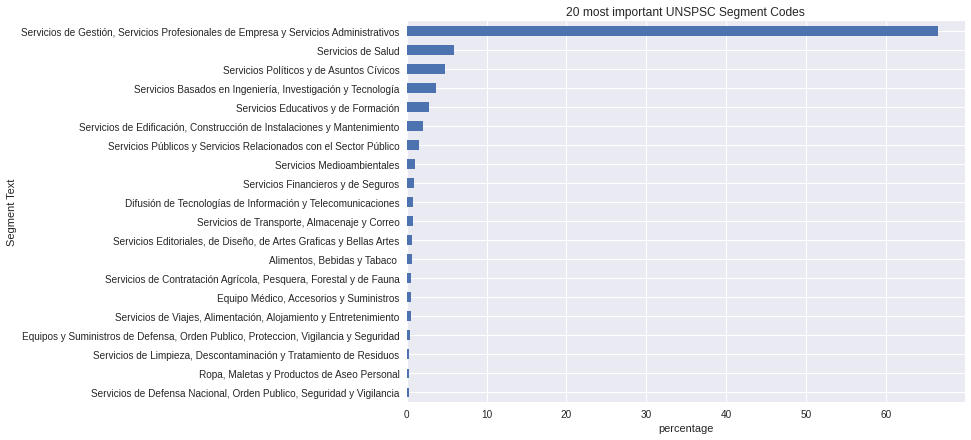

In [11]:
plt.figure(figsize=(10,7))
plt.title('20 most important UNSPSC Segment Codes')
plt.ylabel('Segment Text')
plt.xlabel('percentage')
(100*df_sample.segment_text.value_counts(normalize=True)).iloc[:20].sort_values().plot(kind = 'barh');

This plot shows us that we have a unbalanced dataset, where the majority of the UNSPSC codes are in 80 Segment

# Family explorations

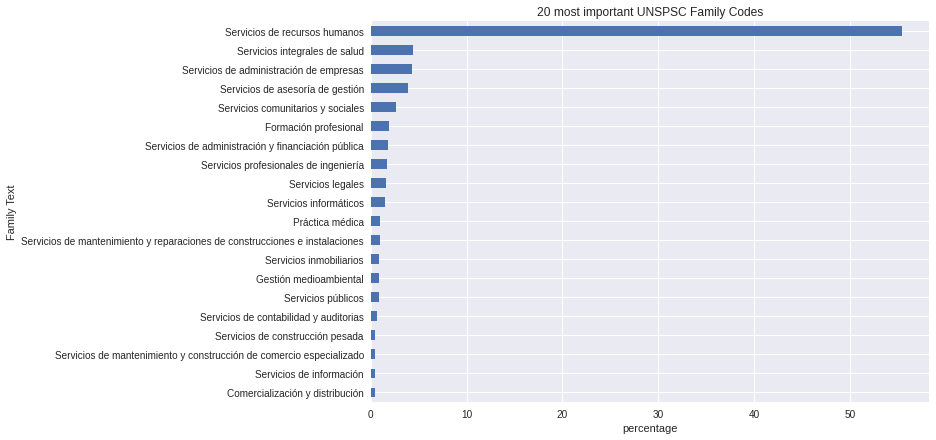

In [12]:
plt.figure(figsize=(10,7))
plt.title('20 most important UNSPSC Family Codes')
plt.ylabel('Family Text')
plt.xlabel('percentage')
(100*df_sample.family_text.value_counts(normalize=True)).iloc[:20].sort_values().plot(kind = 'barh');

# Class explorations

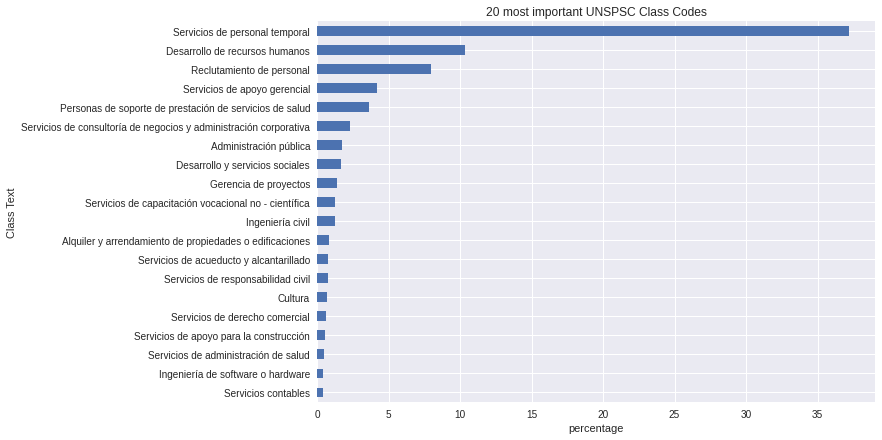

In [13]:
plt.figure(figsize=(10,7))
plt.title('20 most important UNSPSC Class Codes')
plt.ylabel('Class Text')
plt.xlabel('percentage')
(100*df_sample.class_text.value_counts(normalize=True)).iloc[:20].sort_values().plot(kind = 'barh');

# Commodity explorations

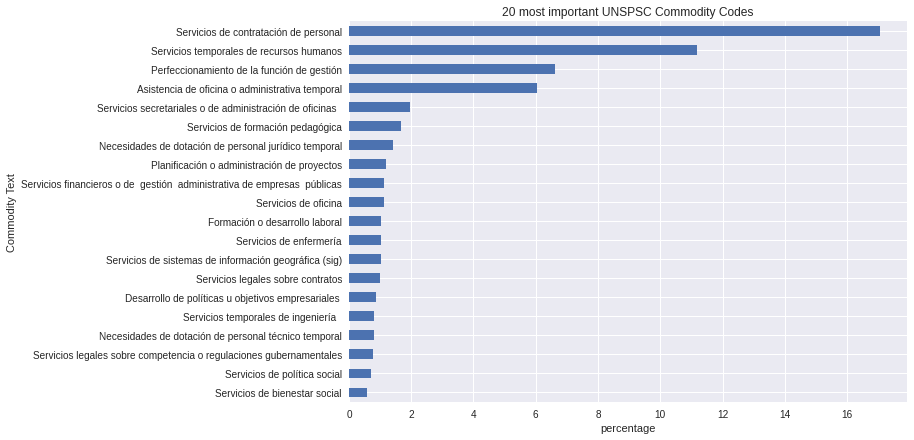

In [14]:
plt.figure(figsize=(10,7))
plt.title('20 most important UNSPSC Commodity Codes')
plt.ylabel('Commodity Text')
plt.xlabel('percentage')
(100*df_sample.commodity_text.value_counts(normalize=True)).iloc[:20].sort_values().plot(kind = 'barh');

# Text Standarization

Now we take a quick look at one of the contracts bodies to get a better idea of what we are dealing with.

In [15]:
# Definimos los tokenizer y lemmatizer
wpt = nltk.WordPunctTokenizer()
lem = nltk.WordNetLemmatizer()

# Descargamos las stopwords para espanhol
stop_words = nltk.corpus.stopwords.words('spanish')
# Definimos la función de preprocesamiento
def normalize_document(doc):
    # Se convierten los téxtos a minúsculas
    doc = doc.lower()
    # Se eliminan caracteres especiales
    doc = re.sub(r'[^a-zñàáâãäåèéêëìíîïòóôõöùúûüýÿ\s]', '', doc, re.I|re.A)
    doc = doc.strip()
    # Tokenizado de documento
    tokens = wpt.tokenize(doc)
    # Eliminación de stopwords
    tokens = [token for token in tokens if token not in stop_words]
    # Lematización
    tokens = [lem.lemmatize(token) for token in tokens]
    # Retornamos una versión filtrada del texto
    doc = ' '.join(tokens)
    return doc
# Vectorización de la función
normalize_corpus = np.vectorize(normalize_document)

df_sample['normalize_description'] = df_sample.descripcion_del_proceso.apply(normalize_document)

In [16]:
print(df_sample.loc[1, "descripcion_del_proceso"])
print()
print(df_sample.loc[1, "normalize_description"])

Prestar con plena autonomía técnica y administrativa sus servicios profesionales en sistemas de la información  bibliotecología y archivística en el área de Gestión Documental  para apoyar la misión de la Biblioteca de la FUGA.

prestar plenum autonomía técnica administrativa servicios profesionales sistemas información bibliotecología archivística área gestión documental apoyar misión biblioteca fuga


In [17]:
print(df_sample.loc[2, "descripcion_del_proceso"])
print()
print(df_sample.loc[2, "normalize_description"])

Prestación de Servicios Profesionales como Abogado (a) en la Subsecretaría de Acceso a Servicíos de Justicia  en desarrollo del proyecto denominado:  Fortalecimiento de los servicios de acceso a la justicia en Santiago de Cali  Según ficha EBI No. 26002080

prestación servicios profesionales abogado subsecretaría acceso servicíos justicia desarrollo proyecto denominado fortalecimiento servicios acceso justicia santiago cali según ficha ebi


# Description Exploration

<AxesSubplot:title={'center':'Most Repeated Words'}, xlabel='Frequencies', ylabel='Words'>

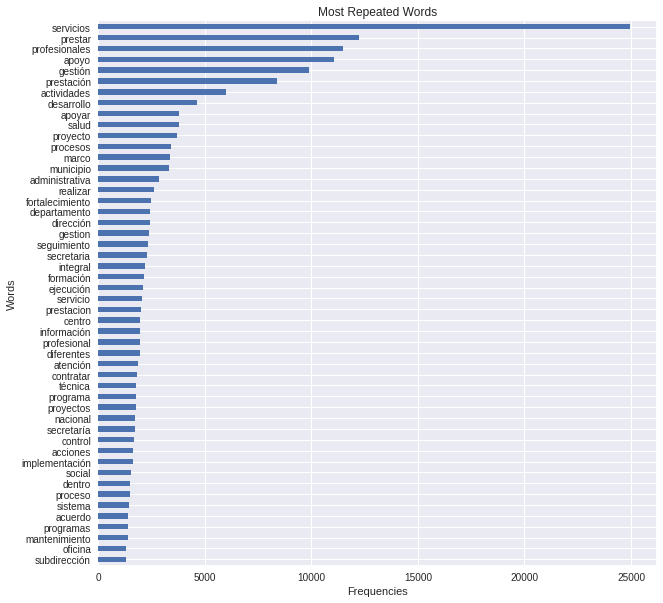

In [18]:
plt.figure(figsize=(10,10))
plt.title('Most Repeated Words')
plt.ylabel('Words')
plt.xlabel('Frequencies')
df_sample.normalize_description.str.split(expand=True).stack().value_counts().iloc[:50].sort_values().plot(kind = 'barh')

In [19]:
def n_gram_representation(data, n_size, k_most=50, plot=True):

    cv = CountVectorizer(ngram_range=(n_size,n_size), analyzer= "word")

    cv_matrix = cv.fit_transform(df_sample.normalize_description)
    
    df = pd.DataFrame(data=cv_matrix.toarray(),columns=cv.get_feature_names())

    def n_gram_barplot(data, k=k_most):
        plt.figure(figsize=(10,10))
        plt.title('Most Repeated {} Grams'.format(n_size))
        plt.ylabel('{} Grams'.format(n_size))
        plt.xlabel('Frequencies')
        data.sum().sort_values(ascending=False).iloc[:k].sort_values().plot(kind = 'barh')

    if plot:

        n_gram_barplot(df)
    
    else:

        return df

In [20]:
n_gram_representation(df_sample, 2)

MemoryError: Unable to allocate 31.8 GiB for an array with shape (30000, 142322) and data type int64

In [ ]:
n_gram_representation(df_sample, 5)

In [ ]:
n_gram_representation(df_sample, 10)

In [ ]:
n_gram_representation(df_sample, 20)

In [ ]:
n_gram_representation(df_sample, 30)

This representation of n_gram gives us the size of the window about how many words we could use to get a smaller representation of the text with approximate contract information. We see that the distribution of 5 grams is similar to that of 10 grams, that is, a sentence of 10 words appears in the same number of documents as one of 5, approximately. This agrees with the aforementioned about documents having a short length.